In [ ]:
# module imports
import numpy as np 
import pandas as pd  
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

In [ ]:
 # model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing dataset
day0_df = pd.read_csv('/content/drive/My Drive/day0_dataset.csv')
train_df = pd.read_csv('/content/drive/My Drive/train_dataset.csv')
test_df = pd.read_csv('/content/drive/My Drive/test_dataset.csv')

In [ ]:
#dropping irrelevant columns

day0_df.drop(['Unnamed: 0','No.','Time','delta'],axis = 1,inplace = True)
train_df.drop(['Unnamed: 0','No.','Time','delta'],axis = 1,inplace = True)
test_df.drop(['Unnamed: 0','No.','Time','delta'],axis = 1,inplace = True)

In [ ]:
df = pd.concat([day0_df,train_df,test_df])
df.head()

,Source,Destination,Protocol,frame length,tcp len,src port,dst port,Flags,window size,Sequence Number,attack
0,10.1.47.195,142.251.42.106,TLSv1.2,93,39.0,56824,443,24,255,1,0
1,10.1.47.195,142.251.42.106,TLSv1.2,433,379.0,56826,443,24,253,1,0
2,142.251.42.106,10.1.47.195,TCP,60,0.0,443,56826,16,557,1,0
3,142.251.42.106,10.1.47.195,TCP,60,0.0,443,56824,16,343,1,0
4,142.251.42.106,10.1.47.195,TLSv1.2,121,67.0,443,56826,24,557,1,0


In [ ]:
print(df.shape)

(1241759, 11)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1241759 entries, 0 to 312111
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Source           1241759 non-null  object 
 1   Destination      1241759 non-null  object 
 2   Protocol         1241759 non-null  object 
 3   frame length     1241759 non-null  int64  
 4   tcp len          1241759 non-null  float64
 5   src port         1241759 non-null  int64  
 6   dst port         1241759 non-null  int64  
 7   Flags            1241759 non-null  int64  
 8   window size      1241759 non-null  int64  
 9   Sequence Number  1241759 non-null  int64  
 10  attack           1241759 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 113.7+ MB


In [ ]:
#encoding categorical datatype

print(df['Protocol'].unique())
df['Protocol'].value_counts()

['TLSv1.2' 'TCP' 'TLSv1.3' 'TLSv1' 'HTTP' 'HTTP/XML' 'STUN' 'SSL' 'OCSP'
 'SSLv2' 'DNS' 'SMB' 'PKIX-CRL' 'IRC']


TCP         1113129
TLSv1.3       66272
TLSv1.2       58810
HTTP           2476
TLSv1           949
STUN             54
HTTP/XML         21
DNS              18
SMB              14
OCSP              6
SSL               4
IRC               3
SSLv2             2
PKIX-CRL          1
Name: Protocol, dtype: int64

In [ ]:
df = df[(df.Protocol == 'TCP') | (df.Protocol == 'TLSv1.3') | (df.Protocol == 'TLSv1.2') | (df.Protocol == 'HTTP') | (df.Protocol == 'TLSv1')]

In [ ]:
df.reset_index(drop = True,inplace = True)

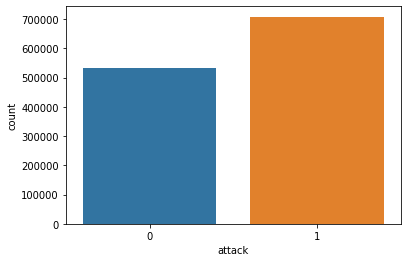

In [ ]:
sns.countplot(x = df['attack']) #0: normal traffic, 1: attack traffic

In [ ]:
df['Protocol'] = df['Protocol'].apply(lambda x: 43 if x == 'HTTP' else 6)

In [ ]:
df['tcp len'] = df['tcp len'].astype(np.int64)

In [ ]:
df.shape

(1241636, 11)

In [ ]:
# n = 10000  #chunk row size
n = 3000
# n = 20000
list_df = [df[i:i+n] for i in range(0,df.shape[0],n)]

In [ ]:
len_df = len(list_df)
len_df

414

In [ ]:
df_arr = np.array(list_df, dtype = 'object')
df_arr.shape

(414,)

In [ ]:
frames = []  #n = 3000
for i in range(1,21):
  frames.append(df_arr[i])

for i in range(230,250):
  frames.append(df_arr[i])
train_frames = pd.concat(frames)

In [ ]:
train_frames.attack.value_counts()

0    60760
1    59240
Name: attack, dtype: int64

In [ ]:
x_train = train_frames.iloc[:, 2:10]
y_train = train_frames.iloc[:, 10]

In [ ]:
df_arr[370].attack.value_counts()

1    2974
0      26
Name: attack, dtype: int64

In [ ]:
test_frames = pd.concat([df_arr[1],df_arr[2],df_arr[3],df_arr[4],df_arr[5],df_arr[370],df_arr[371],df_arr[372],df_arr[373],df_arr[374]])
x_test = test_frames.iloc[:,2:10]
y_test = test_frames.iloc[:, 10]

In [ ]:
print(x_train.shape[0])
print(x_test.shape[0])

120000
30000


In [ ]:
#Function to calculate Hellinger distance between two probability distributions
def hellinger(p, q):
  dis = math.sqrt(sum(
      [(math.sqrt(p_i) - math.sqrt(q_i))**2 for p_i, q_i in zip(p, q)]
      )/2)
  return dis

In [ ]:
##Function to get average probability distribution from a batch of probability distibutions 
def getProba(index, model, n):
  x_test = df_arr[index].iloc[:, 2:10]
  proba = model.predict_proba(x_test)
  t = [0, 0]
  for i in range(x_test.shape[0]):
    t[0]+=proba[i][0]
    t[1]+=proba[i][1]

  t[0]/=n
  t[1]/=n
  return t

In [ ]:

##Calculating Hellinger distance between the probability distribution of the training set and other batches
##input : model (Trained model on a classification ML algorithm)
##output : Hellinger distance between the training set and other remaining sets 
def hellingerForAll(model,n) :
  model_proba = getProba(0, model, n)
  dist = []
  for i in range(1, len_df):
    y_pred = getProba(i, model, n)
    dist.append(hellinger(model_proba, y_pred))
  return dist

In [ ]:
##Function to plot scatter plot 
##input : dist (A list containing the Hellinger distances of the different sets)
##        title (Title of Graph, a string)
def plotGraph(dist, title): 
  y = dist
  x = [i for i in range(1, len_df)]
  plt.scatter(x, y, label= "stars", color= "red",
              marker= "*", s=30)

  plt.xlabel('Batch number')
  plt.ylabel('Hellinger Distance')
  plt.title(title)
  plt.show()

In [ ]:
##Using Logistic Regression
lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
##Calculating Hellinger distance between the probability distribution of the training set and other batches
hellinger_dist_lr = hellingerForAll(lr_model, n)
hellinger_dist_lr

[0.0806312949902133,
 0.10005848593766464,
 0.11137010594367672,
 0.10920889525045024,
 0.10163279837355187,
 0.07314523867970632,
 0.0786778466505254,
 0.066699781070062,
 0.08249927916139388,
 0.04185717822030868,
 0.08261374990042605,
 0.11000244566270997,
 0.11419531695834678,
 0.10035742694283918,
 0.14577137916981256,
 0.0898941360233832,
 0.09137402746077831,
 0.13418464734288488,
 0.13282167618073404,
 0.10340484955599905,
 0.10363722419432782,
 0.08551450555016925,
 0.10458669081807007,
 0.10985847172181153,
 0.09072865087398592,
 0.09544006649992093,
 0.1331424640578565,
 0.10905152977627101,
 0.08150093253839423,
 0.11897488792873201,
 0.1118397790707351,
 0.10888146765828091,
 0.09735874539117059,
 0.11674702706653241,
 0.10239636002465917,
 0.10873568442115432,
 0.10709753931385611,
 0.10289802794971926,
 0.08477174801233044,
 0.13509574109401232,
 0.09963480660005226,
 0.10108859318358625,
 0.1106532837601773,
 0.11021192581099132,
 0.09004282928728935,
 0.089493475535637

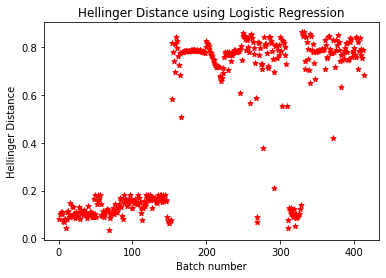

In [ ]:
plotGraph(hellinger_dist_lr, 'Hellinger Distance using Logistic Regression')

In [ ]:
y_pred = lr_model.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9897333333333334


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16364
           1       0.98      1.00      0.99     13636

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [ ]:
svm_model = svm.SVC(probability=True)
svm_model.fit(x_train, y_train)

SVC(probability=True)

In [ ]:
hellinger_dist_svm = hellingerForAll(svm_model,n)
hellinger_dist_svm

[0.15790421654446238,
 0.24346673720314205,
 0.2587704594393879,
 0.26209069164422766,
 0.2512058498020689,
 0.1987161148626261,
 0.23504663734898187,
 0.2324710971355854,
 0.24690651511918169,
 0.2235789080500907,
 0.26599198936889845,
 0.27024953278999525,
 0.2780367971983346,
 0.26875179531024784,
 0.3376969067052148,
 0.24922848635387923,
 0.2911561943008265,
 0.30243896888605054,
 0.29182698058536594,
 0.27692073994292926,
 0.29543599036322027,
 0.2648703162698093,
 0.30185417621030025,
 0.2793511445289883,
 0.29407536000294493,
 0.2767445236702058,
 0.24920538063887246,
 0.2826220606256618,
 0.2960718268290178,
 0.3182521797473068,
 0.32368379218037646,
 0.3015360947418501,
 0.30045025363207034,
 0.3137692114412258,
 0.3152281771299523,
 0.3000104835990634,
 0.2743855997039628,
 0.2949305653168837,
 0.2768157126448691,
 0.31585219346920895,
 0.3240543805106132,
 0.3003615093103873,
 0.2995280928149335,
 0.2958757856121712,
 0.32070821755312257,
 0.30534830884688535,
 0.3137512042

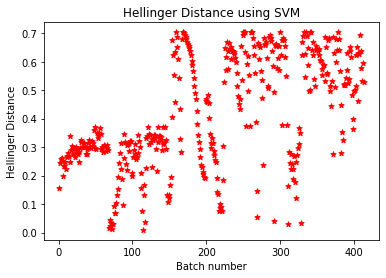

In [ ]:
##Plotting the calculated Hellinger distances
plotGraph(hellinger_dist_svm, 'Hellinger Distance using SVM')

In [ ]:
y_pred = svm_model.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9195


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     16364
           1       0.86      0.99      0.92     13636

    accuracy                           0.92     30000
   macro avg       0.92      0.93      0.92     30000
weighted avg       0.93      0.92      0.92     30000



In [ ]:
##Using Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

GaussianNB()

In [ ]:
hellinger_dist_nb = hellingerForAll(nb_model,n)
hellinger_dist_nb

[0.1340009621559459,
 0.17708578237855557,
 0.20360920894518578,
 0.19526293616317866,
 0.16783334999022506,
 0.11610346941455156,
 0.14331835226928957,
 0.12470380821303047,
 0.1530753205607849,
 0.03931688863434025,
 0.14998735706190436,
 0.23482664472111392,
 0.24290030383412944,
 0.2180124391033053,
 0.3102547235555005,
 0.1881038111915107,
 0.19691447692976743,
 0.2775447660349395,
 0.28261174484260604,
 0.2177022598058379,
 0.22214463228509454,
 0.18870877630273042,
 0.2250492657744903,
 0.2293663912249988,
 0.19126536977768618,
 0.2039602235326131,
 0.285611409628591,
 0.22622239441720166,
 0.17062786846177375,
 0.24953739069755745,
 0.24171897679262988,
 0.23148182565811656,
 0.20809358522066726,
 0.2500723126823766,
 0.22021823526513634,
 0.2342228965031315,
 0.2189495671483657,
 0.21952260665199932,
 0.17465499927240152,
 0.2839683020098744,
 0.20781584899303068,
 0.20686162588702503,
 0.23206617512328181,
 0.23530004430030438,
 0.18463948322415277,
 0.18719859938399244,
 0.2

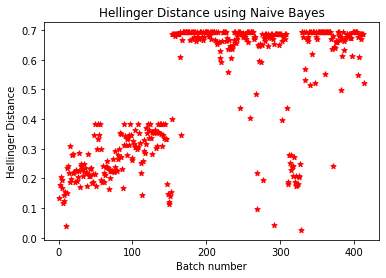

In [ ]:
##Plotting the calculated Hellinger distances
plotGraph(hellinger_dist_nb, 'Hellinger Distance using Naive Bayes')

In [ ]:
y_pred = nb_model.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9522333333333334


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     16364
           1       0.90      1.00      0.95     13636

    accuracy                           0.95     30000
   macro avg       0.95      0.96      0.95     30000
weighted avg       0.96      0.95      0.95     30000



In [ ]:
#K Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)

KNeighborsClassifier()

In [ ]:
hellinger_dist_knn = hellingerForAll(knn_model,n)
hellinger_dist_knn

[0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.11293835902708246,
 0.11869291229719271,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.11035090018579992,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.10816913612815837,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.11869291229719271,
 0.10624662004980287,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.12444510358246884,
 0.10922095842771527,
 0.1115795173048587,
 0.09870033572197946,
 0.09870033572197946,
 0.12444510358246884,
 0.12444510358246884,
 0.10624662004980287,
 0.12444510358246884,
 0.08801825879204445,
 0.12444510358246884,
 0.11157951

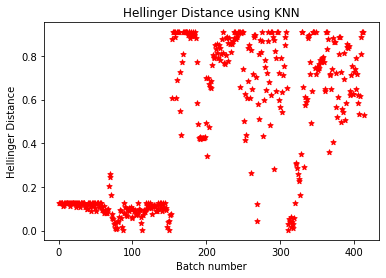

In [ ]:
##Plotting the calculated Hellinger distances
plotGraph(hellinger_dist_knn, 'Hellinger Distance using KNN')

In [ ]:
y_pred = knn_model.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9792


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16364
           1       1.00      0.96      0.98     13636

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000



In [ ]:
#Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
hellinger_dist_rf = hellingerForAll(rf_model,n)
hellinger_dist_rf

[0.06298993215482332,
 0.06298993215482332,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.05981176194336952,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.0642796196795004,
 0.06245570964164307,
 0.0642796196795004,
 0.0642796196795004,
 0.06204577953948922,
 0.06204577953948922,
 0.022070731116674493,
 0.05637957325050119,
 0.049313678129113574,
 0.03697726256188697,
 0.0672552484738966,
 0.060565622070957274,
 0.05819543023986813,
 0.05921069501631058,
 0.0685633262964689,
 0.06355368557190517,
 0.06298686765741666,
 0.06476589182977524,
 0.06785605575675464,
 0.06469333606217366,
 0.06722934829505543,
 0.06409159194471024,
 0.059985703896067326,
 0.0611768406211416,
 0.0664174885218645,
 0.05986256312239252,
 0.060504341770298654,
 0.06628714178617968,
 0.06257188903802172,
 0.06419758919314864,
 0.06429688539622834,
 0.06797203889551826,
 

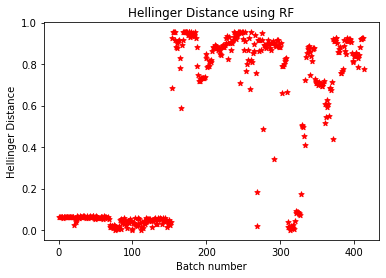

In [ ]:
##Plotting the calculated Hellinger distances
plotGraph(hellinger_dist_rf, 'Hellinger Distance using RF')

In [ ]:
y_pred = rf_model.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.9860666666666666


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16364
           1       1.00      0.97      0.98     13636

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000



## Threshold Calculation

Case 1: UL: mean (Mu)

In [ ]:
##Function to calculate the mean and standard deviation of a list of Hellinger distances
def uhl(dist):
  dist = np.array(dist)
  mean = np.mean(dist)
  stddev = np.std(dist)
  return mean,stddev

In [ ]:
##Function to plot the Hellinger distances along with thresholds
def plot(dist, mean, stddev, i, title):
  y = dist
  x = [i for i in range(1, len(dist)+1)]
  # plt.axhline(y = uhl, color = 'blue') ##Upper limit passed in function
  plt.axhline(y = mean + i*(stddev/2), color = 'green') ##Varying the threshold by adding standard deviation 
  # plt.axhline(y = uhl - stddev/2, color = 'yellow') ##Varying the threshold by subtracting standard deviation
  # plt.scatter(x, y, label= "stars", color= "red",
              # marker= ".", s=30)
  plt.plot(x, y)

  plt.xlabel('Batch number')
  plt.ylabel('Hellinger Distance')
  plt.title(title)
  plt.show()

In [ ]:
mean_lr, stddev_lr = uhl(hellinger_dist_lr)
mean_rf, stddev_rf = uhl(hellinger_dist_rf)
mean_svm, stddev_svm = uhl(hellinger_dist_svm) 
mean_knn, stddev_knn = uhl(hellinger_dist_knn)
mean_nb, stddev_nb = uhl(hellinger_dist_nb)

In [ ]:
##Returns list of labels for all the frames
## 1 : attack, 0: normal
##input : hellinger_dis = list of the calculated Hellinger distances
##        mean = (mu) mean of the Hellinger distances 
##        stddev = standard deviation of the Hellinger distances
##        i = i for different cases {-1, 0, 1}

def list_of_labels(hellinger_dis, mean, stddev, i):
  uhl = mean + i * stddev/2
  l = []
  for i in range(0, len(hellinger_dis)):
    if hellinger_dis[i] <= uhl:
      l.append(0)
    else:
      l.append(1)

  return l

In [ ]:
test_list_lr = list_of_labels(hellinger_dist_lr, mean_lr, stddev_lr, 0)
test_list_nb = list_of_labels(hellinger_dist_nb, mean_nb, stddev_nb, 0)
test_list_svm = list_of_labels(hellinger_dist_svm, mean_svm, stddev_svm, 0)
test_list_knn = list_of_labels(hellinger_dist_knn, mean_knn, stddev_knn, 0)
test_list_rf = list_of_labels(hellinger_dist_rf, mean_rf, stddev_rf, 0)

In [ ]:
df_arr[0]['attack'].values

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# if number of attack packets are more than 50% in a profile
# then we mark it as an attack batch, else normal batch
real = []
for i in range(1, len_df):
  cnt = 0
  for j in df_arr[i]['attack'].values:
    cnt += j
    
  if(cnt >= n/2):
    real.append(1)
  else:
    real.append(0)

In [ ]:
##Function to return the metrics
## tp : True Positive
## tn : True Negative
## fp : False Positive
## fn : False Negative

def give_metrics(real, predicted):
  tp, tn, fp, fn = 0, 0, 0, 0
  for i in range(0, len(predicted)):
    if(real[i] == 1 and real[i] == predicted[i]):
      tp+=1
    elif real[i] == 1 and predicted[i] == 0:
      fn+=1
    elif real[i] == 0 and predicted[i] == 1:
      fp+=1
    else:
      tn+=1

  return tp, tn, fp, fn

In [ ]:
##Function to calculate the evaluation metrics 
## Precision, Recall, Accuracy, F1 score

def checker(tp, tn, fp, fn):
  precision, recall, accuracy, f1 = 0, 0, 0, 0
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  f1 = (2*precision*recall)/(precision+recall)

  dic = {"precision" : precision, "recall" : recall, "accuracy" : accuracy, "f1_score" : f1}

  # print(precision," ", recall," ", accuracy," ", f1)
  return dic

In [ ]:
test_lists = [test_list_lr, test_list_nb, test_list_knn,test_list_rf,test_list_svm]  #TODO: SVM

In [ ]:
# Case 1: Threshold Values
print("LR: ",mean_lr)
print("KNN: ",mean_knn)
print("NB: ",mean_nb)
print("SVM: ",mean_svm)
print("RF: ",mean_rf)

LR:  0.49916565571712057
KNN:  0.47500854663594816
NB:  0.4903016874895394
SVM:  0.4187769886310937
RF:  0.5054086058800916


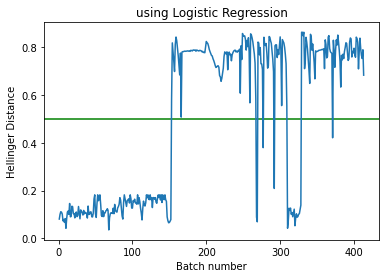

In [ ]:
plot(hellinger_dist_lr, mean_lr, stddev_lr, 0, "using Logistic Regression")

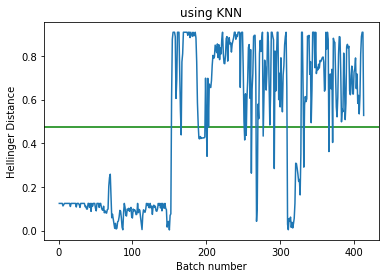

In [ ]:
plot(hellinger_dist_knn, mean_knn, stddev_knn, 0, "using KNN")

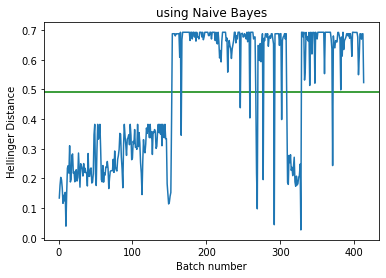

In [ ]:
plot(hellinger_dist_nb, mean_nb, stddev_nb, 0, "using Naive Bayes")

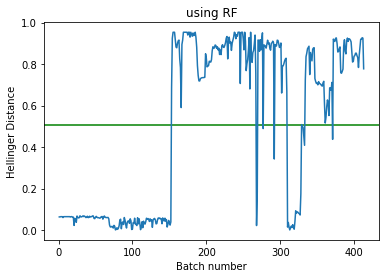

In [ ]:
plot(hellinger_dist_rf, mean_rf, stddev_rf, 0, "using RF")

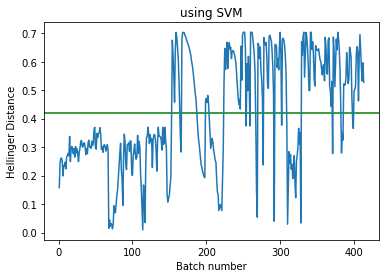

In [ ]:
plot(hellinger_dist_svm, mean_svm, stddev_svm, 0, "using SVM")

In [ ]:
##Function to return evaluation metrics for all the four algorithms in sequence : Logistic Regression, Naive Bayes, SVM, k Nearest Neighbor
## Returns a list of dictionary with precision, recall, accuracy and f1 score of all the algorithms
def total_metrics(test_lists):
  l = []
  for i in range(len(test_lists)):
    tp, tn, fp, fn = give_metrics(real, test_lists[i])
    temp = checker(tp, tn, fp, fn)
    l.append(temp)
  
  return l

In [ ]:
metrics_case_1 = total_metrics(test_lists) ##0 : logistic regression, 1 : naive bayes, 2 : k nearest neighbors, 3: RF, 4: SVM
for dic in metrics_case_1:
  print(dic)

{'precision': 1.0, 'recall': 0.9916317991631799, 'accuracy': 0.9951573849878934, 'f1_score': 0.995798319327731}
{'precision': 1.0, 'recall': 0.9623430962343096, 'accuracy': 0.9782082324455206, 'f1_score': 0.9808102345415778}
{'precision': 1.0, 'recall': 0.9205020920502092, 'accuracy': 0.9539951573849879, 'f1_score': 0.9586056644880174}
{'precision': 1.0, 'recall': 0.9748953974895398, 'accuracy': 0.9854721549636803, 'f1_score': 0.9872881355932204}
{'precision': 1.0, 'recall': 0.8075313807531381, 'accuracy': 0.8886198547215496, 'f1_score': 0.8935185185185186}


Case 2: UL = mean + stddev/2

In [ ]:
test_list_lr =  list_of_labels(hellinger_dist_lr, mean_lr, stddev_lr, 1)
test_list_nb = list_of_labels(hellinger_dist_nb, mean_nb, stddev_nb, 1)
test_list_svm = list_of_labels(hellinger_dist_svm, mean_svm, stddev_svm, 1)
test_list_knn = list_of_labels(hellinger_dist_knn, mean_knn, stddev_knn,1)
test_list_rf = list_of_labels(hellinger_dist_rf, mean_rf, stddev_rf, 1)

In [ ]:
test_lists = [test_list_lr, test_list_nb, test_list_knn,test_list_rf,test_list_svm]  #TODO: SVM

In [ ]:
# Case 2: Threshold Values
print("LR: ",mean_lr + stddev_lr/2)
print("KNN: ",mean_knn + stddev_knn/2)
print("NB: ",mean_nb + stddev_nb/2)
print("SVM: ",mean_svm + stddev_svm/2)
print("RF: ",mean_rf + stddev_rf/2)

LR:  0.6614965133746169
KNN:  0.6447492364128227
NB:  0.5963953745164382
SVM:  0.5153590389116224
RF:  0.7049319949833559


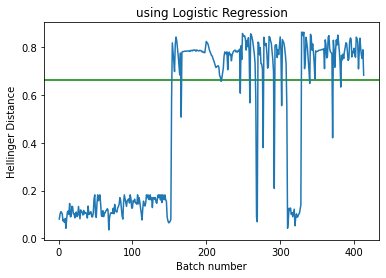

In [ ]:
plot(hellinger_dist_lr, mean_lr, stddev_lr, 1, "using Logistic Regression")

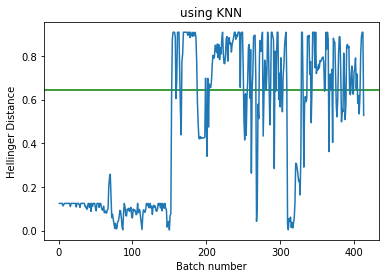

In [ ]:
plot(hellinger_dist_knn, mean_knn, stddev_knn, 1, "using KNN")

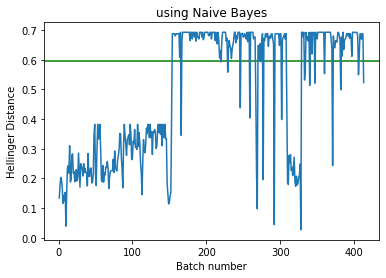

In [ ]:
plot(hellinger_dist_nb, mean_nb, stddev_nb, 1, "using Naive Bayes")

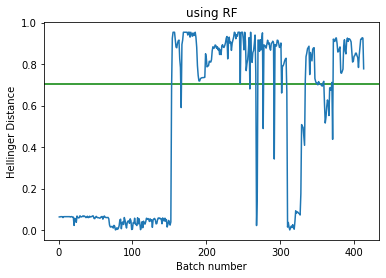

In [ ]:
plot(hellinger_dist_rf, mean_rf, stddev_rf, 1, "using RF")

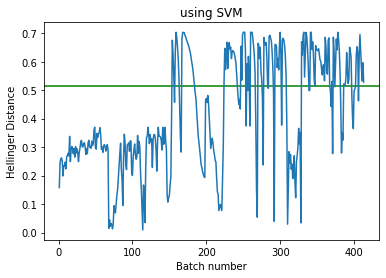

In [ ]:
plot(hellinger_dist_svm, mean_svm, stddev_svm, 1, "using SVM")

In [ ]:
metrics_case_2 = total_metrics(test_lists) ##0 : logistic regression, 1 : naive bayes, 2 : k nearest neighbors, 3: RF, 4: SVM
for dic in metrics_case_2:
  print(dic)

{'precision': 1.0, 'recall': 0.9497907949790795, 'accuracy': 0.9709443099273608, 'f1_score': 0.9742489270386265}
{'precision': 1.0, 'recall': 0.9163179916317992, 'accuracy': 0.9515738498789347, 'f1_score': 0.9563318777292577}
{'precision': 1.0, 'recall': 0.7322175732217573, 'accuracy': 0.8450363196125908, 'f1_score': 0.8454106280193237}
{'precision': 1.0, 'recall': 0.891213389121339, 'accuracy': 0.937046004842615, 'f1_score': 0.9424778761061947}
{'precision': 1.0, 'recall': 0.6652719665271967, 'accuracy': 0.8062953995157385, 'f1_score': 0.7989949748743719}


Case 3: UL = mean - stddev/2

In [ ]:
test_list_lr =  list_of_labels(hellinger_dist_lr, mean_lr, stddev_lr, -1)
test_list_nb = list_of_labels(hellinger_dist_nb, mean_nb, stddev_nb, -1)
test_list_svm = list_of_labels(hellinger_dist_svm, mean_svm, stddev_svm, -1)
test_list_knn = list_of_labels(hellinger_dist_knn, mean_knn, stddev_knn,-1)
test_list_rf = list_of_labels(hellinger_dist_rf, mean_rf, stddev_rf, -1)

In [ ]:
test_lists = [test_list_lr, test_list_nb, test_list_knn,test_list_rf,test_list_svm]  #TODO: SVM

In [ ]:
# Case 3: Threshold Values
print("LR: ",mean_lr - stddev_lr/2)
print("KNN: ",mean_knn - stddev_knn/2)
print("NB: ",mean_nb - stddev_nb/2)
print("SVM: ",mean_svm - stddev_svm/2)
print("RF: ",mean_rf - stddev_rf/2)

LR:  0.33683479805962424
KNN:  0.30526785685907365
NB:  0.3842080004626406
SVM:  0.322194938350565
RF:  0.30588521677682734


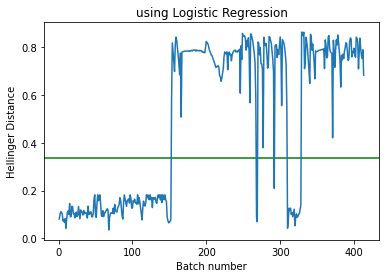

In [ ]:
plot(hellinger_dist_lr, mean_lr, stddev_lr, -1, "using Logistic Regression")

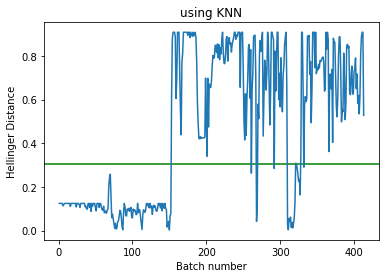

In [ ]:
plot(hellinger_dist_knn, mean_knn, stddev_knn, -1, "using KNN")

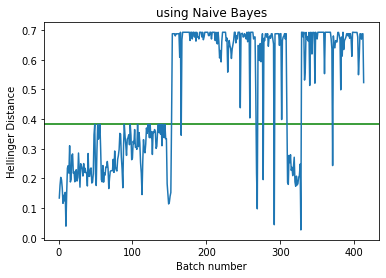

In [ ]:
plot(hellinger_dist_nb, mean_nb, stddev_nb, -1, "using Naive Bayes")

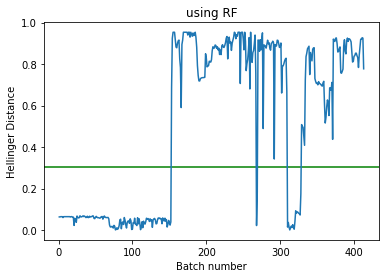

In [ ]:
plot(hellinger_dist_rf, mean_rf, stddev_rf, -1, "using RF")

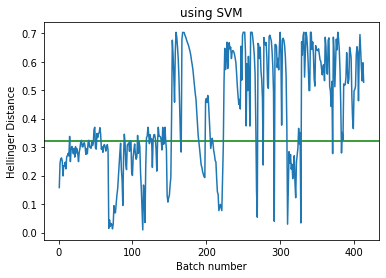

In [ ]:
plot(hellinger_dist_svm, mean_svm, stddev_svm, -1, "using SVM")

In [ ]:
metrics_case_3 = total_metrics(test_lists) ##0 : logistic regression, 1 : naive bayes, 2 : k nearest neighbors, 3: RF, 4: SVM
for dic in metrics_case_3:
  print(dic)

{'precision': 1.0, 'recall': 1.0, 'accuracy': 1.0, 'f1_score': 1.0}
{'precision': 1.0, 'recall': 0.9874476987447699, 'accuracy': 0.9927360774818402, 'f1_score': 0.9936842105263157}
{'precision': 0.9875, 'recall': 0.9916317991631799, 'accuracy': 0.9878934624697336, 'f1_score': 0.989561586638831}
{'precision': 0.9958333333333333, 'recall': 1.0, 'accuracy': 0.9975786924939467, 'f1_score': 0.9979123173277662}
{'precision': 0.8636363636363636, 'recall': 0.8744769874476988, 'accuracy': 0.847457627118644, 'f1_score': 0.8690228690228691}
